## ファイルのインポート 

In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd

In [2]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time


## 各ウェブサイトにURLをテーブルから取得

In [3]:
urls=[]
for i in range(7,10):
    urls.append("https://www.football-lab.jp/nago/match/?year=201{}".format(i))
    
    home_aways=[]
    soups=[]
    for j in range(0,len(urls)):
        res = requests.get(urls[j])
        soup = BeautifulSoup(res.text, "html.parser")
        soups.append(soup)
        #home のみ取り出す
        home_elems = soup.find_all('span', class_='home')
        home_aways.append(home_elems)

        home_urls=[]
        for i in range(0,len(home_aways)):
            for j in range(0,len(home_aways[i])):
                Parent = home_aways[i][j].parent.parent #親をたどる
                elems = Parent.find('a').next_element.next_element.next_element.find('a')['href'] #子要素を取り出す。
                home_urls.append(elems)
                        
    
    # res = requests.get(url)

In [4]:
#リスト型にする
home_urls=['https://www.football-lab.jp'+home_urls[i] for i in range(len(home_urls))]
home_urls


['https://www.football-lab.jp/nago/report/?year=2017&month=02&date=26',
 'https://www.football-lab.jp/nago/report/?year=2017&month=03&date=04',
 'https://www.football-lab.jp/nago/report/?year=2017&month=03&date=18',
 'https://www.football-lab.jp/nago/report/?year=2017&month=04&date=01',
 'https://www.football-lab.jp/nago/report/?year=2017&month=04&date=08',
 'https://www.football-lab.jp/nago/report/?year=2017&month=04&date=22',
 'https://www.football-lab.jp/nago/report/?year=2017&month=05&date=03',
 'https://www.football-lab.jp/nago/report/?year=2017&month=05&date=17',
 'https://www.football-lab.jp/nago/report/?year=2017&month=06&date=03',
 'https://www.football-lab.jp/nago/report/?year=2017&month=06&date=25',
 'https://www.football-lab.jp/nago/report/?year=2017&month=07&date=08',
 'https://www.football-lab.jp/nago/report/?year=2017&month=07&date=16',
 'https://www.football-lab.jp/nago/report/?year=2017&month=08&date=06',
 'https://www.football-lab.jp/nago/report/?year=2017&month=08&da

## `ウェブサイト立ち上げ

In [6]:
# ブラウザ起動
PATH = "C:\Program Files (x86)\chromedriver.exe"
# options = Options()
#options.add_argument("--incognito") # プライベートブラウズモードで開く

driver = webdriver.Chrome(executable_path = PATH)

# windows size設定(80%表示で最適な window size)
driver.set_window_size(840,1000)
#Webドライバーのタイムアウト時間を10秒に設定
wait = WebDriverWait(driver, 10)

## テーブル取得

In [7]:
def get_table(urls):
    dfs=[]
    for url in urls: #一旦３つくらい
        driver.get(url)
    # CLASS名指定したページ上の要素が読み込まれるまで待機（15秒でタイムアウト判定）
        WebDriverWait(driver, 15).until(EC.presence_of_element_located((By.CLASS_NAME, 'statsTbl6 ')))
        elem_table = driver.find_element_by_xpath("/html/body/article/div[10]/table[2]")
        time.sleep(3)
        html = elem_table.get_attribute('outerHTML')
        df = pd.read_html(html) #ここではリスト

        #対戦チームの
        elem_home = driver.find_element_by_css_selector('#nago > article > div:nth-child(10) > div:nth-child(6) > em:nth-child(1)')
        elem_home_team = driver.find_element_by_css_selector('#nago > article > div:nth-child(10) > div:nth-child(6) > em:nth-child(2) > span.dsktp')
        elem_away = driver.find_element_by_css_selector('#nago > article > div:nth-child(10) > div:nth-child(6) > em:nth-child(4)')
        elem_away_team = driver.find_element_by_css_selector('#nago > article > div:nth-child(10) > div:nth-child(6) > em:nth-child(5) > span.dsktp')
        elem_day = driver.find_element_by_css_selector('#nago > article > div.boxHalfSP.l')
        dfs.append([df,elem_home.text,elem_home_team.text,elem_away.text,elem_away_team.text,elem_day.text])
    return dfs
    # teams_home_away.append([elem_home.text,elem_home_team.text,elem_away.text,elem_away_team.text])

In [8]:
home_dfs = get_table(home_urls)

In [9]:
def change_column_name(dfs):
    #列名をそれぞれ変える
    change_dfs=[]
    for i in range(len(dfs)):
        stats_df = pd.DataFrame(dfs[i][0][0])
            # カラム名変更
        columns_name = [dfs[i][1]+"_"+dfs[i][2]+"_平均_"+dfs[i][5],
                            dfs[i][1]+"_"+dfs[i][2]+"_成功率_"+dfs[i][5],
                            dfs[i][1]+"_"+dfs[i][2]+"_総数_"+dfs[i][5],
                            "スタッツ",
                            dfs[i][3]+"_"+dfs[i][4]+"_総数_"+dfs[i][5],
                            dfs[i][3]+"_"+dfs[i][4]+"_成功率_"+dfs[i][5],
                            dfs[i][3]+"_"+dfs[i][4]+"_平均+"+dfs[i][5]]
        stats_df.columns = columns_name
        change_dfs.append(stats_df)
        # stats_df.dropna(axis = 0, how = 'any', inplace=True) #一つでもNanが行に含まれてたら削除
        # stats_df.set_index("スタッツ", inplace=True, drop=True) #Dropでsetindexの列を残さない
    return change_dfs

In [10]:
home_dfs = change_column_name(home_dfs)

In [11]:
def organize_df(dfs):
    organize_df1=[]
    for i in range(len(dfs)):
        # stats_df = pd.DataFrame(dfs[i][0][0])

        #データフレームを整理する
        dfs[i].dropna(axis = 0, how = 'any', inplace=True) #一つでもNanが行に含まれてたら削除
        dfs[i].set_index("スタッツ", inplace=True, drop=True) #Dropでsetindexの列を残さない

        #置換
        dfs[i].iloc[:,2] = dfs[i].iloc[:,2].str.replace("m", "")
        dfs[i].iloc[:,2] = dfs[i].iloc[:,2].str.replace("%", "")
        dfs[i].iloc[:,2] = dfs[i].iloc[:,2].str.replace(",", "")
        dfs[i].iloc[:,3] = dfs[i].iloc[:,3].str.replace("m", "")
        dfs[i].iloc[:,3] = dfs[i].iloc[:,3].str.replace("%", "")
        dfs[i].iloc[:,3] = dfs[i].iloc[:,3].str.replace(",", "")
        dfs[i].iloc[:,1] = dfs[i].iloc[:,1].str.replace("%", "")
        dfs[i].iloc[:,1] = dfs[i].iloc[:,1].str.replace(")", "")
        dfs[i].iloc[:,1] = dfs[i].iloc[:,1].str.replace("(", "")
        dfs[i].iloc[:,1] = dfs[i].iloc[:,1].str.replace("-", "0")
        dfs[i].iloc[:,4] = dfs[i].iloc[:,4].str.replace("%", "")
        dfs[i].iloc[:,4] = dfs[i].iloc[:,4].str.replace(")", "")
        dfs[i].iloc[:,4] = dfs[i].iloc[:,4].str.replace("(", "")
        dfs[i].iloc[:,4] = dfs[i].iloc[:,4].str.replace("-", "0")
        
                #float型にする
        dfs[i].iloc[:,0] = dfs[i].iloc[:,0].astype(float)
        dfs[i].iloc[:,1] = dfs[i].iloc[:,1].astype(float)
        dfs[i].iloc[:,2] = dfs[i].iloc[:,2].astype(float)
        dfs[i].iloc[:,3] = dfs[i].iloc[:,3].astype(float)
        dfs[i].iloc[:,4] = dfs[i].iloc[:,4].astype(float)
        dfs[i].iloc[:,5] = dfs[i].iloc[:,5].astype(float)


        organize_df1.append(dfs[i])

    # return organize_df

In [12]:
organize_df(home_dfs)

In [13]:
home_dfs[0]

,HOME_名古屋グランパス_平均_2017.2.26 14:00 Kick Off,HOME_名古屋グランパス_成功率_2017.2.26 14:00 Kick Off,HOME_名古屋グランパス_総数_2017.2.26 14:00 Kick Off,AWAY_ファジアーノ岡山_総数_2017.2.26 14:00 Kick Off,AWAY_ファジアーノ岡山_成功率_2017.2.26 14:00 Kick Off,AWAY_ファジアーノ岡山_平均+2017.2.26 14:00 Kick Off
スタッツ,,,,,,
シュート,13.7,15.4,13.0,10.0,0.0,12.1
枠内シュート,4.8,0.0,5.0,2.0,0.0,3.5
PKによるシュート,0.1,0.0,0.0,0.0,0.0,0.0
パス,614.7,79.9,617.0,476.0,77.5,373.6
クロス,12.7,33.3,12.0,8.0,37.5,14.0
直接ＦＫ,16.1,0.0,20.0,10.0,0.0,11.4
間接ＦＫ,2.8,0.0,1.0,5.0,0.0,2.8
ＣＫ,4.5,0.0,3.0,3.0,0.0,4.5
スローイン,25.2,92.6,27.0,22.0,90.9,25.9


## awaygameのデータ取得

In [14]:
#home のみ取り出す
home_aways = soup.find_all('span', class_='away')
away_url=[]
for i in home_aways:
#    home_away = soup.find('span', class_='away') #awayを見つけ出す
    Parent = i.parent.parent #親をたどる
    elems = Parent.find('a').next_element.next_element.next_element.find('a')['href'] #子要素を取り出す。
    away_url.append(elems)
# home_url
#リスト型にする
# pickup_links=[elem.attrs["href"] for elem in elems]
away_url=['https://www.football-lab.jp'+away_url[i] for i in range(len(away_url))]
away_url


['https://www.football-lab.jp/nago/report/?year=2019&month=02&date=23',
 'https://www.football-lab.jp/nago/report/?year=2019&month=03&date=09',
 'https://www.football-lab.jp/nago/report/?year=2019&month=03&date=17',
 'https://www.football-lab.jp/nago/report/?year=2019&month=04&date=05',
 'https://www.football-lab.jp/nago/report/?year=2019&month=04&date=13',
 'https://www.football-lab.jp/nago/report/?year=2019&month=05&date=04',
 'https://www.football-lab.jp/nago/report/?year=2019&month=05&date=17',
 'https://www.football-lab.jp/nago/report/?year=2019&month=06&date=01',
 'https://www.football-lab.jp/nago/report/?year=2019&month=06&date=15',
 'https://www.football-lab.jp/nago/report/?year=2019&month=06&date=30',
 'https://www.football-lab.jp/nago/report/?year=2019&month=07&date=13',
 'https://www.football-lab.jp/nago/report/?year=2019&month=08&date=04',
 'https://www.football-lab.jp/nago/report/?year=2019&month=08&date=18',
 'https://www.football-lab.jp/nago/report/?year=2019&month=09&da

In [15]:
away_dfs = get_table(away_url)

In [16]:
away_dfs = change_column_name(away_dfs)

In [17]:
organize_df(away_dfs)

In [18]:
away_dfs[1]

,HOME_ガンバ大阪_平均_2019.3.9 15:00 Kick Off,HOME_ガンバ大阪_成功率_2019.3.9 15:00 Kick Off,HOME_ガンバ大阪_総数_2019.3.9 15:00 Kick Off,AWAY_名古屋グランパス_総数_2019.3.9 15:00 Kick Off,AWAY_名古屋グランパス_成功率_2019.3.9 15:00 Kick Off,AWAY_名古屋グランパス_平均+2019.3.9 15:00 Kick Off
スタッツ,,,,,,
ゴール期待値,1.433,0.0,1.576,1.462,0.0,1.583
シュート,14.600,10.0,10.000,17.000,11.8,14.200
枠内シュート,4.900,0.0,6.000,9.000,0.0,4.500
PKによるシュート,0.100,0.0,1.000,0.000,0.0,0.000
パス,587.000,76.8,479.000,514.000,78.2,609.000
クロス,15.100,12.5,8.000,8.000,37.5,14.800
直接ＦＫ,11.000,0.0,15.000,16.000,0.0,13.600
間接ＦＫ,1.400,0.0,1.000,7.000,0.0,2.600
ＣＫ,5.500,0.0,3.000,7.000,0.0,5.600


## スタジアム毎に分ける

In [19]:
#²017-2019の全試合のURLから、soupを取得する
soups=[]
for i in range(7,10):
    res = requests.get("https://www.football-lab.jp/nago/match/?year=201{}".format(i))
    soup = BeautifulSoup(res.text, "html.parser")
    soups.append(soup)

In [20]:
#瑞穂パロと豊田スの各試合のURLを取得する
mizuho_url=[]
toyota_url=[]
for i in range(0,len(soups)):

    for tr in soups[i].select('table.statsTbl10 tbody tr'):
        tds = tr.select('td')
        if tds[6].text=="豊田ス":
            toyota_url.append(tds[4].find("a")['href'] )

        elif tds[6].text=="パロ瑞穂":
            mizuho_url.append(tds[4].find("a")['href'] )


toyota_url=['https://www.football-lab.jp'+toyota_url[i] for i in range(len(toyota_url))]
mizuho_url=['https://www.football-lab.jp'+mizuho_url[i] for i in range(len(mizuho_url))]

## 瑞穂パロマ

In [21]:
# toyota_dfs = get_table(toyota_url)
mizuho_dfs = get_table(mizuho_url)


In [22]:
len(mizuho_dfs)
mizuho_dfs[0]

[[          今季平均         成功率          総数  Unnamed: 3   総数.1    成功率.1  今季平均.1
  0         シュート        シュート        シュート        シュート    NaN      NaN     NaN
  1         13.7     (15.4%)          13        シュート     10   (0.0%)    12.1
  2       枠内シュート      枠内シュート      枠内シュート      枠内シュート    NaN      NaN     NaN
  3          4.8           -           5      枠内シュート      2        -     3.5
  4    PKによるシュート   PKによるシュート   PKによるシュート   PKによるシュート    NaN      NaN     NaN
  5          0.1           -           0   PKによるシュート      0        -     0.0
  6           パス          パス          パス          パス    NaN      NaN     NaN
  7        614.7     (79.9%)         617          パス    476  (77.5%)   373.6
  8          クロス         クロス         クロス         クロス    NaN      NaN     NaN
  9         12.7     (33.3%)          12         クロス      8  (37.5%)    14.0
  10        直接ＦＫ        直接ＦＫ        直接ＦＫ        直接ＦＫ    NaN      NaN     NaN
  11        16.1           -          20        直接ＦＫ     10        -    11.4

In [23]:
# toyota_dfs = change_column_name(toyota_dfs)
mizuho_dfs = change_column_name(mizuho_dfs)

In [24]:
# toyota_dfs = organize_df(toyota_dfs)
organize_df(mizuho_dfs)

## 総数のみを抽出してまとめる

In [25]:
def chose_df(dfs):
    concat_df=[]
    for i in range(len(dfs)):
        concat_df.append(dfs[i].iloc[:,2])
    concat_df = pd.DataFrame(concat_df)
    return concat_df

In [26]:
m=chose_df(mizuho_dfs)
m

,シュート,枠内シュート,PKによるシュート,パス,クロス,直接ＦＫ,間接ＦＫ,ＣＫ,スローイン,ドリブル,...,警告,退場,３０ｍライン進入,ペナルティエリア進入,攻撃回数,チャンス構築率,ボール支配率,総走行距離,スプリント,ゴール期待値
HOME_名古屋グランパス_総数_2017.2.26 14:00 Kick Off,13.0,5.0,0.0,617.0,12.0,20.0,1.0,3.0,27.0,11.0,...,2.0,0.0,39.0,13.0,145.0,9.0,52.1,NaN,NaN,NaN
HOME_名古屋グランパス_総数_2017.3.18 14:00 Kick Off,8.0,1.0,0.0,620.0,12.0,19.0,2.0,1.0,20.0,13.0,...,1.0,0.0,33.0,11.0,121.0,6.6,59.6,NaN,NaN,NaN
HOME_名古屋グランパス_総数_2017.4.8 14:00 Kick Off,9.0,5.0,0.0,504.0,17.0,23.0,2.0,4.0,33.0,11.0,...,3.0,0.0,42.0,18.0,143.0,6.3,60.2,NaN,NaN,NaN
HOME_名古屋グランパス_総数_2017.4.22 14:00 Kick Off,22.0,4.0,0.0,802.0,26.0,19.0,2.0,10.0,18.0,6.0,...,0.0,0.0,62.0,29.0,145.0,15.2,62.4,NaN,NaN,NaN
HOME_名古屋グランパス_総数_2017.5.17 19:00 Kick Off,19.0,7.0,0.0,399.0,17.0,18.0,4.0,7.0,44.0,16.0,...,2.0,0.0,32.0,18.0,152.0,12.5,57.8,NaN,NaN,NaN
HOME_名古屋グランパス_総数_2017.6.25 18:30 Kick Off,8.0,1.0,0.0,584.0,3.0,12.0,6.0,1.0,22.0,13.0,...,1.0,0.0,27.0,6.0,104.0,7.7,53.0,NaN,NaN,NaN
HOME_名古屋グランパス_総数_2017.7.16 18:00 Kick Off,7.0,3.0,0.0,357.0,11.0,18.0,2.0,1.0,24.0,7.0,...,2.0,0.0,27.0,9.0,137.0,5.1,44.1,NaN,NaN,NaN
HOME_名古屋グランパス_総数_2017.8.6 18:30 Kick Off,17.0,10.0,0.0,562.0,10.0,19.0,1.0,3.0,23.0,12.0,...,1.0,0.0,39.0,14.0,120.0,14.2,49.8,NaN,NaN,NaN
HOME_名古屋グランパス_総数_2017.8.20 18:00 Kick Off,18.0,7.0,0.0,827.0,17.0,12.0,7.0,3.0,19.0,10.0,...,0.0,0.0,60.0,21.0,109.0,16.5,58.9,NaN,NaN,NaN
HOME_名古屋グランパス_総数_2017.9.9 18:00 Kick Off,18.0,4.0,0.0,812.0,18.0,7.0,4.0,8.0,22.0,8.0,...,2.0,0.0,77.0,29.0,115.0,15.7,58.7,NaN,NaN,NaN


## 豊田スタジアム

In [27]:
toyota_dfs = get_table(toyota_url)

In [28]:
toyota_dfs = change_column_name(toyota_dfs)
organize_df(toyota_dfs)

In [29]:
t = chose_df(toyota_dfs)

## データ可視化

In [30]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font='Yu Gothic')

In [31]:
# #indexに名前をつける
# index_list=[]
# for i in range(len(t.index)):
#     index_list.append("toyota_game:{}".format(i+1))
# t.index=index_list

In [32]:
t

,シュート,枠内シュート,PKによるシュート,パス,クロス,直接ＦＫ,間接ＦＫ,ＣＫ,スローイン,ドリブル,...,警告,退場,３０ｍライン進入,ペナルティエリア進入,攻撃回数,チャンス構築率,ボール支配率,総走行距離,スプリント,ゴール期待値
HOME_名古屋グランパス_総数_2017.3.4 14:00 Kick Off,10.0,1.0,0.0,431.0,12.0,10.0,3.0,10.0,31.0,18.0,...,1.0,0.0,21.0,11.0,147.0,6.8,43.1,NaN,NaN,NaN
HOME_名古屋グランパス_総数_2017.4.1 17:00 Kick Off,21.0,9.0,0.0,656.0,12.0,15.0,2.0,2.0,17.0,16.0,...,2.0,0.0,41.0,11.0,139.0,15.1,56.0,NaN,NaN,NaN
HOME_名古屋グランパス_総数_2017.5.3 15:00 Kick Off,10.0,5.0,0.0,637.0,19.0,15.0,3.0,6.0,25.0,12.0,...,2.0,0.0,46.0,12.0,144.0,6.9,64.0,NaN,NaN,NaN
HOME_名古屋グランパス_総数_2017.6.3 14:00 Kick Off,19.0,10.0,0.0,686.0,22.0,16.0,5.0,8.0,22.0,23.0,...,0.0,0.0,52.0,28.0,151.0,12.6,64.2,NaN,NaN,NaN
HOME_名古屋グランパス_総数_2017.7.8 18:00 Kick Off,18.0,8.0,1.0,491.0,10.0,12.0,3.0,5.0,28.0,5.0,...,1.0,0.0,42.0,16.0,127.0,14.2,49.5,NaN,NaN,NaN
HOME_名古屋グランパス_総数_2017.8.12 18:00 Kick Off,18.0,8.0,0.0,657.0,6.0,16.0,5.0,2.0,24.0,17.0,...,3.0,0.0,65.0,19.0,135.0,13.3,61.1,NaN,NaN,NaN
HOME_名古屋グランパス_総数_2017.8.26 18:00 Kick Off,15.0,4.0,1.0,648.0,14.0,15.0,3.0,4.0,19.0,16.0,...,4.0,1.0,52.0,19.0,116.0,12.9,56.7,NaN,NaN,NaN
HOME_名古屋グランパス_総数_2017.11.11 14:00 Kick Off,9.0,2.0,0.0,449.0,7.0,16.0,1.0,1.0,32.0,8.0,...,0.0,0.0,40.0,13.0,137.0,6.6,51.0,NaN,NaN,NaN
HOME_名古屋グランパス_総数_2018.3.3 14:00 Kick Off,13.0,7.0,0.0,511.0,9.0,22.0,3.0,6.0,15.0,16.0,...,0.0,0.0,40.0,11.0,126.0,10.3,47.3,113033.0,165.0,NaN
HOME_名古屋グランパス_総数_2018.3.18 19:00 Kick Off,9.0,4.0,0.0,657.0,4.0,11.0,7.0,4.0,18.0,12.0,...,0.0,0.0,47.0,8.0,122.0,7.4,48.3,117252.0,161.0,NaN


In [33]:
#スタジアムのカラムを作る
name_list=[]
for i in range(len(t.index)):
    name_list.append("toyota")
t["stadium"]=name_list

In [34]:
m_index_list=[]
for i in range(len(m.index)):
    m_index_list.append("mizuho_game:{}".format(i+1))

In [35]:
# m.index=m_index_list

In [36]:
name_list=[]
for i in range(len(m.index)):
    name_list.append("mizuho")
m["stadium"]=name_list

In [37]:
df=pd.concat([t,m])


In [38]:
year_list=[]
for i in range(len(df.index)):
    year_list.append(df.index[i][17:21])

In [39]:
df["year"]=year_list

In [53]:
#csv保存
#次からここを読んで行う　df = pd.read_csv('sample.csv')

df.to_csv("nagoya_games.csv")

In [72]:
df

,シュート,枠内シュート,PKによるシュート,パス,クロス,直接ＦＫ,間接ＦＫ,ＣＫ,スローイン,ドリブル,...,３０ｍライン進入,ペナルティエリア進入,攻撃回数,チャンス構築率,ボール支配率,総走行距離,スプリント,ゴール期待値,stadium,year
HOME_名古屋グランパス_総数_2017.3.4 14:00 Kick Off,10.0,1.0,0.0,431.0,12.0,10.0,3.0,10.0,31.0,18.0,...,21.0,11.0,147.0,6.8,43.1,NaN,NaN,NaN,toyota,2017
HOME_名古屋グランパス_総数_2017.4.1 17:00 Kick Off,21.0,9.0,0.0,656.0,12.0,15.0,2.0,2.0,17.0,16.0,...,41.0,11.0,139.0,15.1,56.0,NaN,NaN,NaN,toyota,2017
HOME_名古屋グランパス_総数_2017.5.3 15:00 Kick Off,10.0,5.0,0.0,637.0,19.0,15.0,3.0,6.0,25.0,12.0,...,46.0,12.0,144.0,6.9,64.0,NaN,NaN,NaN,toyota,2017
HOME_名古屋グランパス_総数_2017.6.3 14:00 Kick Off,19.0,10.0,0.0,686.0,22.0,16.0,5.0,8.0,22.0,23.0,...,52.0,28.0,151.0,12.6,64.2,NaN,NaN,NaN,toyota,2017
HOME_名古屋グランパス_総数_2017.7.8 18:00 Kick Off,18.0,8.0,1.0,491.0,10.0,12.0,3.0,5.0,28.0,5.0,...,42.0,16.0,127.0,14.2,49.5,NaN,NaN,NaN,toyota,2017
HOME_名古屋グランパス_総数_2017.8.12 18:00 Kick Off,18.0,8.0,0.0,657.0,6.0,16.0,5.0,2.0,24.0,17.0,...,65.0,19.0,135.0,13.3,61.1,NaN,NaN,NaN,toyota,2017
HOME_名古屋グランパス_総数_2017.8.26 18:00 Kick Off,15.0,4.0,1.0,648.0,14.0,15.0,3.0,4.0,19.0,16.0,...,52.0,19.0,116.0,12.9,56.7,NaN,NaN,NaN,toyota,2017
HOME_名古屋グランパス_総数_2017.11.11 14:00 Kick Off,9.0,2.0,0.0,449.0,7.0,16.0,1.0,1.0,32.0,8.0,...,40.0,13.0,137.0,6.6,51.0,NaN,NaN,NaN,toyota,2017
HOME_名古屋グランパス_総数_2018.3.3 14:00 Kick Off,13.0,7.0,0.0,511.0,9.0,22.0,3.0,6.0,15.0,16.0,...,40.0,11.0,126.0,10.3,47.3,113033.0,165.0,NaN,toyota,2018
HOME_名古屋グランパス_総数_2018.3.18 19:00 Kick Off,9.0,4.0,0.0,657.0,4.0,11.0,7.0,4.0,18.0,12.0,...,47.0,8.0,122.0,7.4,48.3,117252.0,161.0,NaN,toyota,2018


In [41]:
# sns.catplot(x="警告", kind="count",  hue="stadium",data=df,aspect=2)
# plt.xticks(fontsize=12)

In [42]:
# sns.countplot(x="直接ＦＫ", hue="stadium", palette="Set1", data=df)
# plt.xticks(fontsize=12)

In [43]:
# sns.histplot(x="直接ＦＫ", data=df, hue="stadium", binwidth=1, palette={"toyota":"blue", "mizuho":"Orange"})

In [44]:
import math

In [45]:
# # スタージェスの公式で適切なbinsの値を求める
# sturges = lambda n: math.ceil(math.log2(n*2))

# sturges(len(df['直接ＦＫ']))


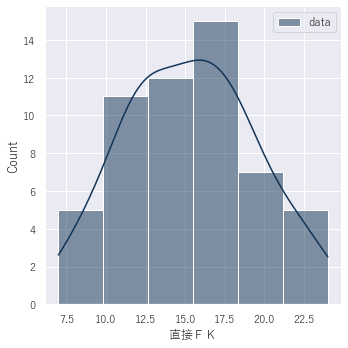

In [46]:
sns.displot(
    df['直接ＦＫ'], bins=6, color='#123456', label='data',
    kde=True
)
plt.legend()
plt.show()

In [47]:
# from pylab import rcParams
# rcParams['figure.figsize'] = 10, 10 # グラフのサイズを大きくする
# df.hist(bins=6, alpha=0.6)
# plt.tight_layout() # グラフ同士が重ならないようにする
# plt.show()

In [48]:
# sns.pairplot(df, hue='stadium', palette="husl")

In [49]:
# sns.displot(df.iloc[:,1], bins=5, hue="stadium",  kde=True)
# sns.displot(df.iloc[:,2], bins=5,  kde=True)
# sns.displot(df.iloc[:,3], bins=5,  kde=True)
# sns.displot(df.iloc[:,4], bins=5,  kde=True)
# sns.displot(df.iloc[:,5], bins=5,  kde=True)
# sns.displot(df.iloc[:,6], bins=5,  kde=True)
# sns.displot(df.iloc[:,7], bins=5,  kde=True)
# plt.legend()

In [50]:
# # 最小値
# x_min = int(df["直接ＦＫ"].min())

# # 最大値
# x_max = int(df["直接ＦＫ"].max())

# # 最小値から最大値の範囲で5間隔
# range_bin_width = range(x_min, x_max, 5)

In [55]:
# range_bin_width

C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


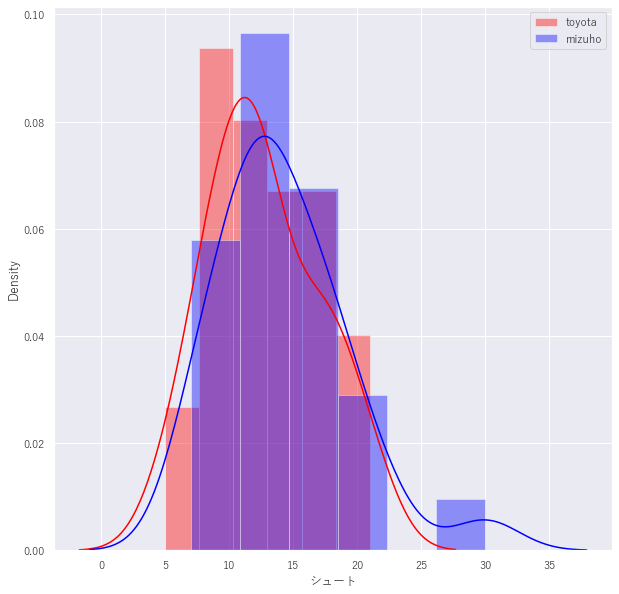

C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


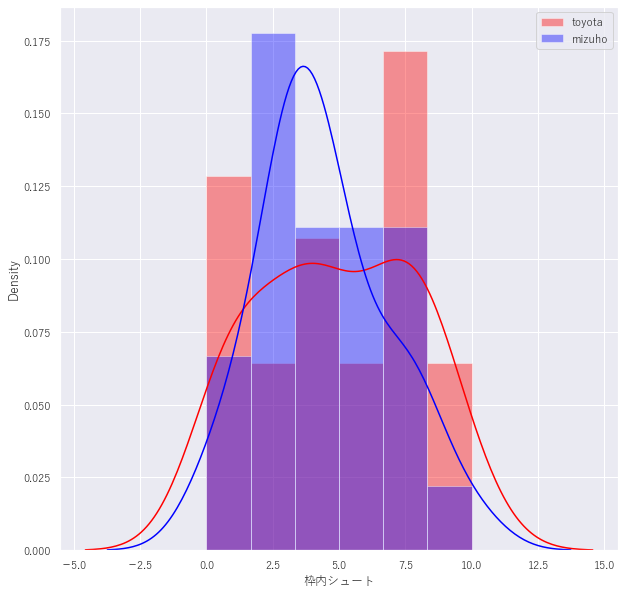

C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


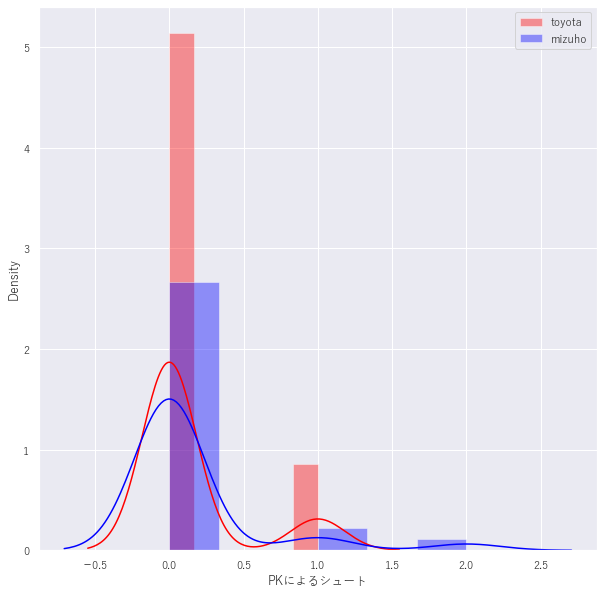

C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


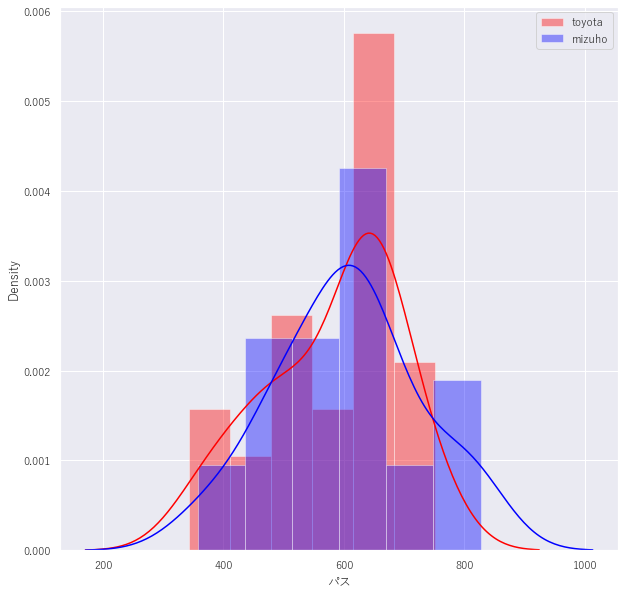

C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


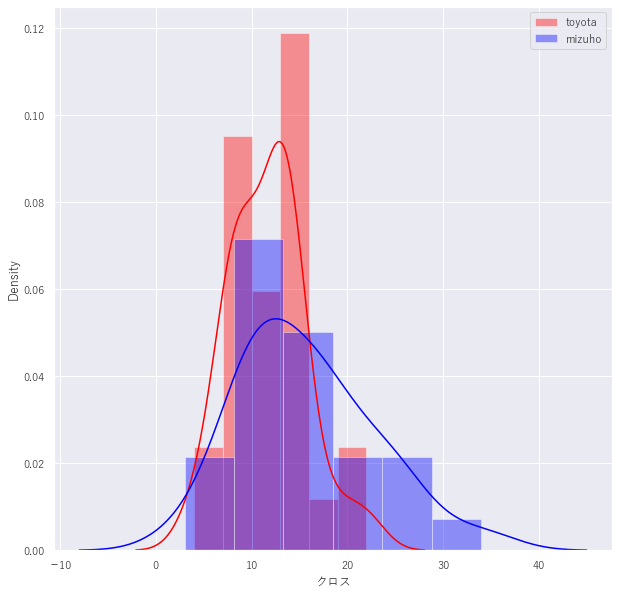

C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


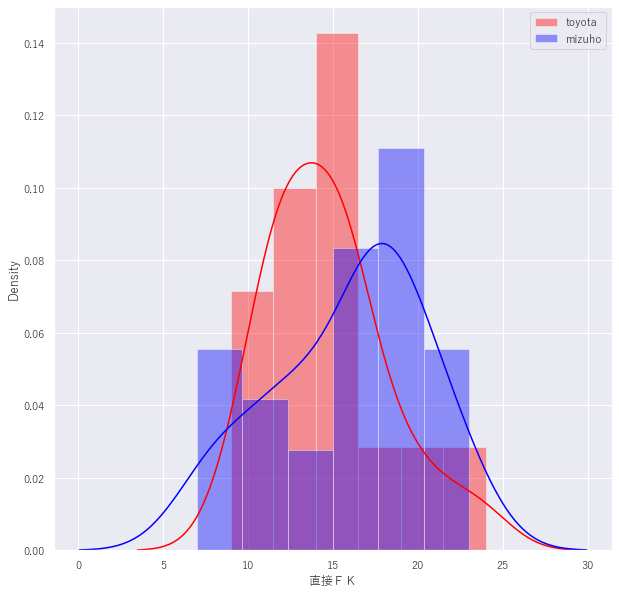

C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


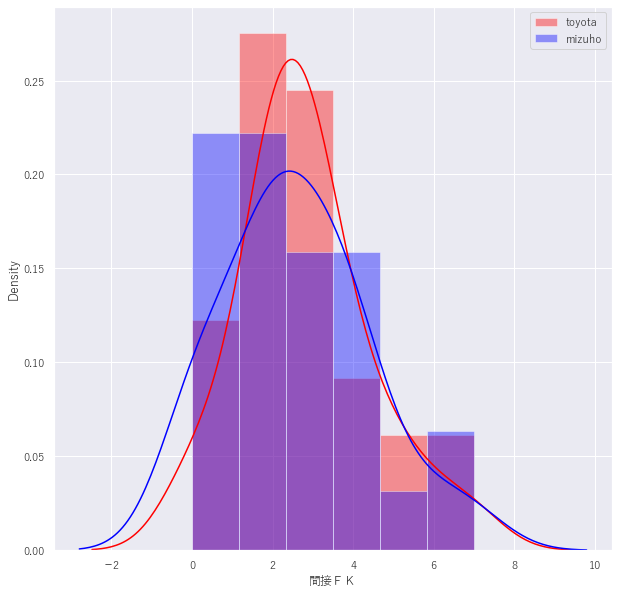

C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


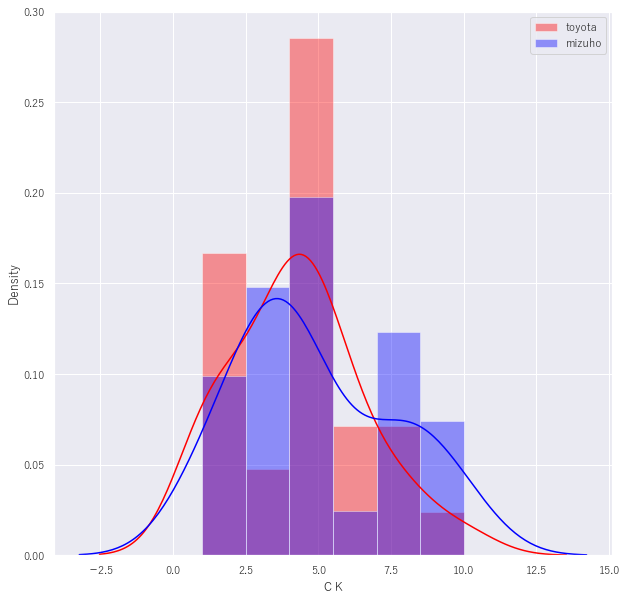

C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


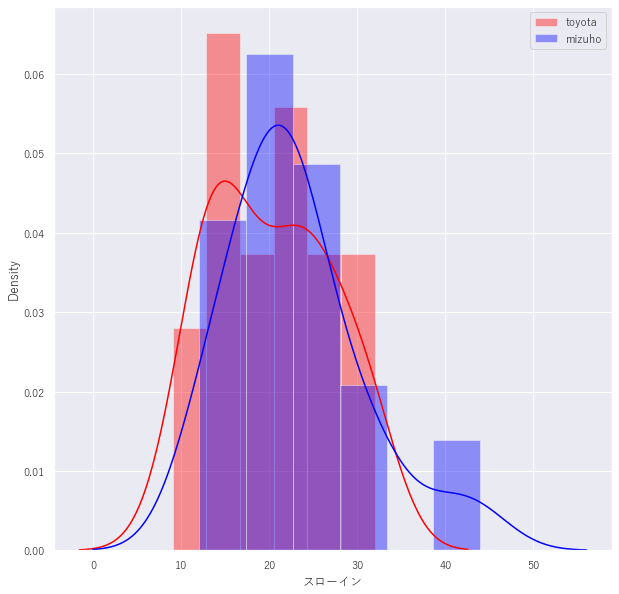

C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


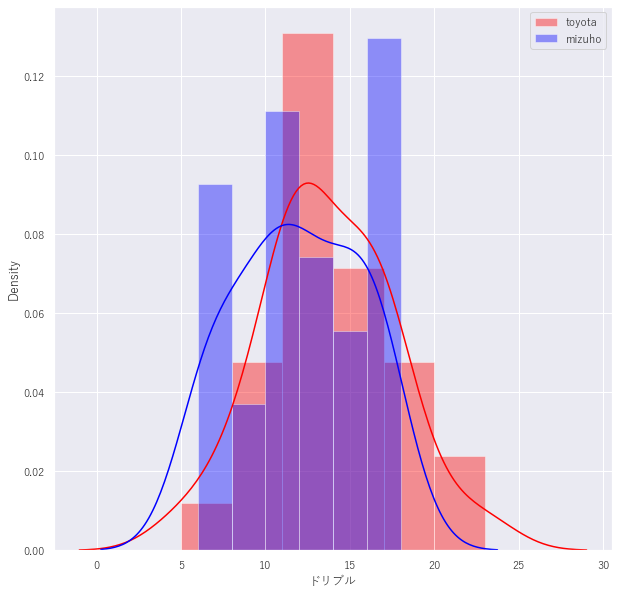

C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


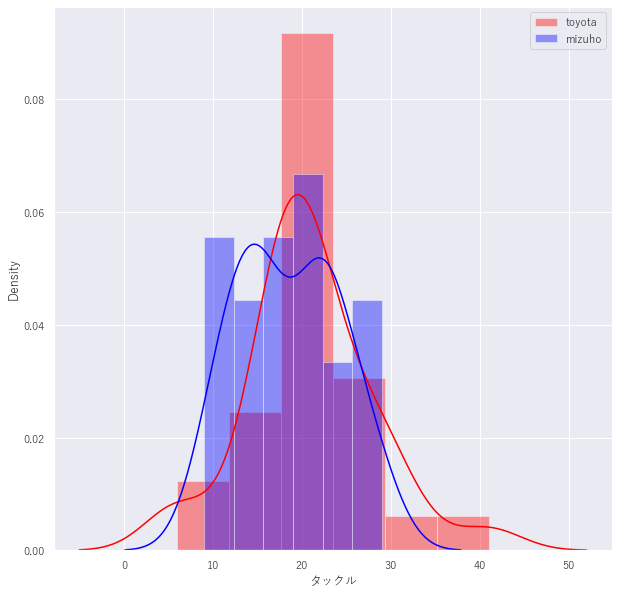

C:\Users\NatsukaHashizume\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

In [ ]:
# for i in df.columns:

#     stadium_arr = df['stadium'].unique()
#     color_dict = {0:'red', 1:'blue', 2:'green'}

#     for index, item in enumerate(stadium_arr):
#         data = df.query('stadium=="'+item+'"')[i]
#         sns.distplot( #histplotでも可
#             data,
#             bins=sturges(len(data)),
#             color=color_dict[index],
#             kde=True,
#             label=item
#         )
        
#     plt.legend()
#     plt.show()

In [56]:
df.groupby(["year","stadium"]).describe()

シュート                                                     枠内シュート  \
             count       mean       std   min   25%   50%    75%   max  count   
year stadium                                                                    
2017 mizuho   13.0  14.153846  4.947157   7.0   9.0  16.0  18.00  22.0   13.0   
     toyota    8.0  15.000000  4.720775   9.0  10.0  16.5  18.25  21.0    8.0   
2018 mizuho    7.0  11.857143  1.864454   8.0  12.0  12.0  12.50  14.0    7.0   
     toyota   10.0  11.900000  2.469818   8.0  11.0  12.0  13.00  17.0   10.0   
2019 mizuho    7.0  16.714286  6.824326  10.0  12.5  15.0  18.50  30.0    7.0   
     toyota   10.0  11.700000  5.165054   5.0   8.0  11.5  15.25  21.0   10.0   

                        ...   スプリント        ゴール期待値                             \
                  mean  ...     75%    max  count      mean       std    min   
year stadium            ...                                                    
2017 mizuho   5.076923  ...     NaN    NaN    0.0       NaN       NaN    NaN   
     toyota   5.875000  ...     NaN    NaN    0.0       NaN       NaN    NaN   
2018 mizuho   3.285714  ...  164.50  179.0    0.0       NaN       NaN    NaN   
     toyota   5.100000  ...  157.75  165.0    0.0       NaN       NaN    NaN   
2019 mizuho   4.285714  ...  142.50  151.0    7.0  1.717286  0.810730  0.701   
     toyota   3.900000  ...  183.50  196.0   10.0  1.394200  0.618331  0.437   

                                              
                 25%     50%      75%    max  
year stadium                                  
2017 mizuho      NaN     NaN      NaN    NaN  
     toyota      NaN     NaN      NaN    NaN  
2018 mizuho      NaN     NaN      NaN    NaN  
     toyota      NaN     NaN      NaN    NaN  
2019 mizuho   1.1925  1.3040  2.40300  2.825  
     toyota   0.9620  1.3745  1.92025  2.240  

[6 rows x 192 columns]

In [57]:
df_group=df.groupby(["year","stadium"]).sum()
df_group

In [78]:
fks=[]
for i in df_group.index:
    fk_mizuho = df_group.loc[(i[0],'mizuho'),'直接ＦＫ']+df_group.loc[(i[0],'mizuho'),'間接ＦＫ']
    fk_toyota = df_group.loc[(i[0],'toyota'),'直接ＦＫ']+df_group.loc[(i[0],'toyota'),'間接ＦＫ']
    fks.append([fk_mizuho,fk_toyota])
    
len(df[(df["stadium"]=='toyota')&(df["year"]=='2017')])

8

In [102]:
games=[]
for i in years:
    mizuho_games = len(df[(df["stadium"]=='mizuho')&(df["year"]==i)])
    toyota_games = len(df[(df["stadium"]=='toyota')&(df["year"]==i)])
    games.append([mizuho_games,toyota_games])
games=sum(games, []) # 二次元リストを一次元リストへ平坦化

In [103]:
df_group["games"]=games

In [104]:
df_group

シュート  枠内シュート  PKによるシュート      パス    クロス   直接ＦＫ  間接ＦＫ    ＣＫ  \
year stadium                                                               
2017 mizuho   184.0    66.0        0.0  7907.0  178.0  215.0  36.0  63.0   
     toyota   120.0    47.0        2.0  4655.0  102.0  115.0  25.0  38.0   
2018 mizuho    83.0    23.0        4.0  3753.0   95.0  116.0  15.0  27.0   
     toyota   119.0    51.0        2.0  5449.0  110.0  161.0  24.0  41.0   
2019 mizuho   117.0    30.0        0.0  4673.0  152.0   99.0  19.0  42.0   
     toyota   117.0    39.0        0.0  6166.0  114.0  135.0  30.0  41.0   

              スローイン   ドリブル  ...   退場  ３０ｍライン進入  ペナルティエリア進入    攻撃回数  チャンス構築率  \
year stadium                ...                                               
2017 mizuho   318.0  151.0  ...  0.0     613.0       229.0  1680.0    144.0   
     toyota   198.0  115.0  ...  1.0     359.0       129.0  1096.0     88.4   
2018 mizuho   163.0   82.0  ...  2.0     287.0       100.0   887.0     66.1   
     toyota   193.0  136.0  ...  0.0     430.0       139.0  1152.0    105.4   
2019 mizuho   137.0   89.0  ...  1.0     461.0       136.0   792.0    103.6   
     toyota   176.0  132.0  ...  0.0     482.0       150.0  1152.0    101.6   

              ボール支配率      総走行距離   スプリント  ゴール期待値  games  
year stadium                                            
2017 mizuho    724.2        0.0     0.0   0.000     13  
     toyota    445.6        0.0     0.0   0.000      8  
2018 mizuho    374.0   802674.0  1010.0   0.000      7  
     toyota    496.2  1123099.0  1368.0   0.000     10  
2019 mizuho    411.5   764418.0   911.0  12.021      7  
     toyota    541.0  1119858.0  1520.0  13.942     10  

[6 rows x 25 columns]

In [59]:
for i in df_group.index:
    print(i[0],i[1])

2017 mizuho
2017 toyota
2018 mizuho
2018 toyota
2019 mizuho
2019 toyota


In [60]:
fks=[]
for i in df_group.index:
    fk_mizuho = df_group.loc[(i[0],'mizuho'),'直接ＦＫ']+df_group.loc[(i[0],'mizuho'),'間接ＦＫ']
    fk_toyota = df_group.loc[(i[0],'toyota'),'直接ＦＫ']+df_group.loc[(i[0],'toyota'),'間接ＦＫ']
    fks.append([fk_mizuho,fk_toyota])

In [61]:
fks

[[251.0, 140.0],
 [251.0, 140.0],
 [131.0, 185.0],
 [131.0, 185.0],
 [118.0, 165.0],
 [118.0, 165.0]]

In [62]:
#atで値だけを取り出せる
# fk_mizuho = df_group.at['mizuho','直接ＦＫ']+df_group.at['mizuho','間接ＦＫ']
# fk_toyota = df_group.at['toyota','直接ＦＫ']+df_group.at['toyota','間接ＦＫ']

# yellow_mizuho = df_group.at['mizuho','警告']
# yellow_toyota = df_group.at['toyota','警告']

# game_mizuho=(df["stadium"]=='mizuho').sum()
# game_toyota=(df["stadium"]=='toyota').sum()

In [63]:
years = [i[0] for i in df_group.index] #['2017', '2018', '2019']を取り出すために重複を消す。
years=sorted(set(years), key=years.index) #
years

['2017', '2018', '2019']

In [64]:
stats_list=[]
for i in years:
    fk_mizuho = df_group.loc[(i,'mizuho'),'直接ＦＫ']
    fk_toyota = df_group.loc[(i,'toyota'),'直接ＦＫ']
    yellow_mizuho = df_group.loc[(i,'mizuho'),'警告']
    yellow_toyota = df_group.loc[(i,'toyota'),'警告']

    stats_list.append([fk_mizuho,fk_toyota,yellow_mizuho,yellow_toyota])
    


stats_list

[[215.0, 115.0, 19.0, 13.0],
 [116.0, 161.0, 15.0, 11.0],
 [99.0, 135.0, 7.0, 7.0]]

In [123]:
df_stats = pd.DataFrame(stats_list, columns=['fk_mizuho','fk_toyota','yellow_mizuho','yellow_toyota'],index=years)
df_stats


,fk_mizuho,fk_toyota,yellow_mizuho,yellow_toyota
2017,215.0,115.0,19.0,13.0
2018,116.0,161.0,15.0,11.0
2019,99.0,135.0,7.0,7.0


In [105]:
df_group.games

year  stadium
2017  mizuho     13
      toyota      8
2018  mizuho      7
      toyota     10
2019  mizuho      7
      toyota     10
Name: games, dtype: int64

In [150]:
advantage=[]
for i in years:
    game_toyota = df_group.loc[(i,'toyota'),'games']
    game_mizuho = df_group.loc[(i,'mizuho'),'games']
    fk_mizuho = df_stats.at[i,'fk_mizuho']
    fk_toyota = df_stats.at[i,'fk_toyota']
    yellow_mizuho = df_stats.at[i,'yellow_mizuho']
    yellow_toyota = df_stats.at[i,'yellow_toyota']
    fk_count=(fk_mizuho/game_mizuho)-(fk_toyota/game_toyota)
    fk_advantage=(fk_toyota)/(fk_mizuho)*100
    yellow_count=(yellow_toyota/game_toyota)-(yellow_mizuho/game_mizuho)
    yellow_advantage=(yellow_toyota)/(yellow_mizuho)*100    

    advantage.append([fk_count,fk_advantage,yellow_count,yellow_advantage])


In [151]:
advantage=pd.DataFrame(advantage, columns=['fk_count','fk_advantage','yellow_count','yellow_advantage'],index=years)
advantage

,fk_count,fk_advantage,yellow_count,yellow_advantage
2017,2.163462,53.488372,0.163462,68.421053
2018,0.471429,138.793103,-1.042857,73.333333
2019,0.642857,136.363636,-0.300000,100.000000


In [153]:
df_advantage = df_stats.join(advantage)
df_advantage

,fk_mizuho,fk_toyota,yellow_mizuho,yellow_toyota,fk_count,fk_advantage,yellow_count,yellow_advantage
2017,215.0,115.0,19.0,13.0,2.163462,53.488372,0.163462,68.421053
2018,116.0,161.0,15.0,11.0,0.471429,138.793103,-1.042857,73.333333
2019,99.0,135.0,7.0,7.0,0.642857,136.363636,-0.300000,100.000000


In [66]:
# fk_count=(fk_mizuho/game_mizuho)-(fk_toyota/game_toyota)
# fk_advantage=(fk_toyota)/(fk_mizuho)*100
# print("FKが1試合当たり {:.2f}回となり、\nホームアドバンテージが {:.2f}%となる。".format(fk_count,fk_advantage))

FKが1試合当たり -1.15回となり、
ホームアドバンテージが 136.36%となる。


In [67]:
# yellow_count=(yellow_toyota/game_toyota)-(yellow_mizuho/game_mizuho)
# yellow_advantage=(yellow_toyota)/(yellow_mizuho)*100
# print("FKが1試合当たり {:.2f}回となり、\nホームアドバンテージが {:.2f}%となる。".format(yellow_count,yellow_advantage))

FKが1試合当たり -0.01回となり、
ホームアドバンテージが 100.00%となる。


In [155]:
df_advantage.index.values

array(['2017', '2018', '2019'], dtype=object)

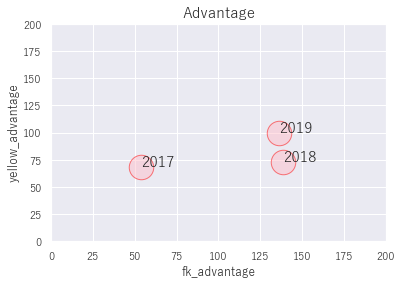

In [181]:
plt.title("Advantage",fontsize = 15)
plt.xlabel("fk_advantage")
plt.ylabel("yellow_advantage")
plt.grid(True)
plt.xlim([0,200]) 
plt.ylim([0,200]) 

x=df_advantage.fk_advantage
y=df_advantage.yellow_advantage
plt.scatter(x, y, s=600, c="pink", alpha=0.5, edgecolors="red")

#use for loop to add annotations to each point in plot 
for i, txt in enumerate(df_advantage.index.values):
    plt.annotate(txt, (x[i], y[i]),fontsize = 15)